In [1]:
import torch
import torch.nn as nn
from base.data import get_data_loaders, get_data_loaders_wandb, get_data_loaders_loocv
from base.train import Trainer, eval_metrics
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class MLPHead(nn.Module):
    def __init__(self, in_dim, out_dim, use_norm, dropout, n_layers):
        super(MLPHead, self).__init__()
        l_sz = [in_dim] + [in_dim//2**(i+1) for i in range(n_layers)] + [out_dim]
        layers = []
        for i in range(1, len(l_sz)-1):
            layers.append(nn.Linear(l_sz[i-1], l_sz[i]))
            if use_norm == 'batch':
                layers.append(nn.BatchNorm1d(l_sz[i]))
            elif use_norm == 'layer':
                layers.append(nn.LayerNorm(l_sz[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(l_sz[-2], l_sz[-1]))
        self.head = nn.Sequential(*layers)

    def forward(self, x):
        return self.head(x)

In [4]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.n_embeddings = cfg['n_embeddings']
        self.projection = nn.Sequential(
            nn.Linear(cfg['emb_dim'], cfg['emb_latent_dim']),
            nn.LayerNorm(cfg['emb_latent_dim'])
        )
        # in_dim = cfg['emb_latent_dim'] * self.n_embeddings + cfg['transf_dim']
        in_dim = cfg['emb_latent_dim'] * (self.n_embeddings[0] + self.n_embeddings[1]) + cfg['transf_dim']
        out_dim = 1 if cfg['task'] == 'regression' else cfg['num_classes']
        self.head = MLPHead(in_dim, out_dim, cfg['use_layer_norm'], cfg['dropout'], cfg['n_hid_layers'])

    # ENB1: unmodified code
    # EMB2: mutated code
    def forward(self, batch):
        if self.n_embeddings[0]:
            em_feat_1 = self.projection(batch[0])
            if self.n_embeddings[1] == True:
                em_feat_2 = self.projection(batch[1])
                if self.n_embeddings[2]:
                    x = torch.cat([em_feat_1, em_feat_2, batch[2]], dim=1)
                else:
                    x = torch.cat([em_feat_1, em_feat_2], dim=1)
            else:
                if self.n_embeddings[2]:
                    x = torch.cat([em_feat_1, batch[1]], dim=1)
                else:
                    x = em_feat_1
        else:
            if self.n_embeddings[1]:
                em_feat_2 = self.projection(batch[0])
                if self.n_embeddings[2]:
                    x = torch.cat([em_feat_2, batch[1]], dim=1)
                else:
                    x = em_feat_2
        return self.head(x).squeeze(-1)

        # Old version:
        # (EMB1, TRANSF) (case 1)
        # (EMB1, EMB2, TRANSF) (case 2)
        
        # em_feat_1 = self.projection(batch[0])
        # if self.n_embeddings == 1:
        #     x = torch.cat([em_feat_1, batch[1]], dim=1)
        # elif self.n_embeddings == 2:
        #     em_feat_2 = self.projection(batch[1])
        #     x = torch.cat([em_feat_1, em_feat_2, batch[2]], dim=1)
        # return self.head(x).squeeze(-1)

In [5]:
cfg_data = {
    'n_workers': 32,
    'batch_size': 2048,    
    'stratification': 'majority', # 'random', 'binary', 'clustered', 'majority'
    'data_path': '/mnt/fastdata/datasets/lore-loops/web-clang',
    'embedding_model': 'source_coderankembed', # 'llvm_llmcompiler', 'source_codellama', 'source_llmcompiler', 'source_codet5p', 'source_coderankembed'
    'embedding_layer': 'last', # 'last', 'all' (not working yet)
    'n_embeddings': [1, 0, 1], # binary flags for [ref_embedding, transformation_embedding, transformation_encoding]
    'min_transformations': 1, # only loop groups with at least <min> transformations
    'max_transformations': 10000, # only loop groups with at most <max> transformations
    'max_speedup': 2.5, # remove any loop group with a speedup transformation > max_speedup
    'max_source_size': 100000, # only loop groups where reference .C file is at most <max> bytes
    'task': 'classification',  # 'classification', 'regression'
    # [(0, np.float64(0.5)), (2, np.float64(1.5)), (4, np.float64(2.5)), (6, np.float64(3.5))]
    'class_splits': [0, .7, 1, 1.5, 17],
    # 'class_splits': [-100, .5, 0.9999, 1.0001, 1.5, 2.5, 3.5, 100000],
    'classes': ['HSL', 'SL', 'SP', 'HSP'],
    'seed': 4,
    'csv_path': './clang_4.0.0_data_table.csv', # for new data loader
    'benchmark': 'NPB',
    'filters': [('benchmark', '==', 'NPB')],
}
# tr_loader, va_loader, te_loader = get_data_loaders(cfg_data)
# tr_loader, va_loader = get_data_loaders_wandb(cfg_data)
loaders = get_data_loaders_loocv(cfg_data)

Applications: ['BT' 'LU' 'UA-SNU' 'CG' 'SP' 'MG' 'FT' 'IS' 'EP']
Validation application: BT
768
56
3 loop groups removed for this split
768
56
7 loop groups removed for this split
Total datapoints: 52812 Train: 36125 Valid: 16687
Validation application: LU
768
56
2 loop groups removed for this split
768
56
8 loop groups removed for this split
Total datapoints: 52812 Train: 44225 Valid: 8587
Validation application: UA-SNU
768
56
1 loop groups removed for this split
768
56
9 loop groups removed for this split
Total datapoints: 52812 Train: 49091 Valid: 3721
Validation application: CG
768
56
2 loop groups removed for this split
768
56
8 loop groups removed for this split
Total datapoints: 52812 Train: 52568 Valid: 244
Validation application: SP
768
56
0 loop groups removed for this split
768
56
10 loop groups removed for this split
Total datapoints: 52812 Train: 29382 Valid: 23430
Validation application: MG
768
56
2 loop groups removed for this split
768
56
8 loop groups removed for this 

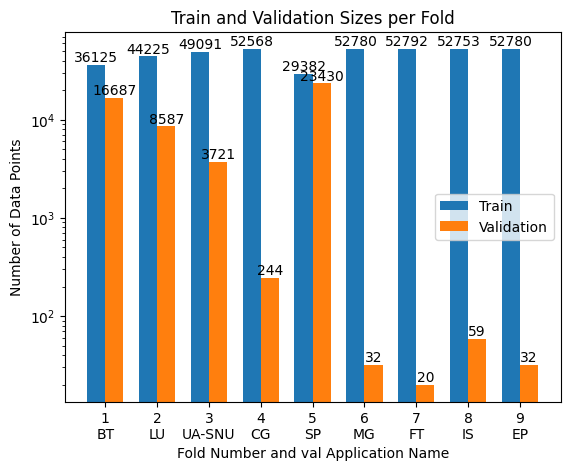

In [6]:
# Show a histogram of the train test split sizes for the number of training data points and validation data points
train_sizes = [len(tr_loader.dataset) for _, tr_loader, _ in loaders]
val_sizes = [len(va_loader.dataset) for _, _, va_loader in loaders]

x = range(1, len(train_sizes) + 1)
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x, train_sizes, width, label='Train')
bars2 = ax.bar([p + width for p in x], val_sizes, width, label='Validation')

ax.set_xlabel('Fold Number and val Application Name')
ax.set_ylabel('Number of Data Points')
ax.set_title('Train and Validation Sizes per Fold')

# Add application names to the fold numbers
app_names = [app for app, _, _ in loaders]
ax.set_xticks([p + width/2 for p in x])
ax.set_xticklabels([f'{i}\n{app}' for i, app in zip(x, app_names)])

ax.legend()

# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Add numbers at the top of each bar
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

plt.show()

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

cfg_model = {
    'n_hid_layers': 3,
    'n_embeddings': cfg_data['n_embeddings'],
    'emb_dim': None, # embedding dimensionality
    'emb_latent_dim': 256, # embedding projection dimensionality
    'transf_dim': None, # transformation dimensionality
    'model_type': 'mlp', # 'attention', 'mlp'
    'task': cfg_data['task'],
    'dropout': 0.2,
    'learning_rate': 1e-3,
    'use_layer_norm': 'batch',
    'weight_decay': 1e-3,
    'max_epochs': 100,
    'num_classes': len(cfg_data['classes'])
}

models = []
for i, (val_app, tr_loader, va_loader) in enumerate(loaders):
    print(f'Fold {i+1} - Validation on {val_app}')
    print(f'Training on {len(tr_loader.dataset)} samples')
    print(f'Validating on {len(va_loader.dataset)} samples')
    
    cfg_model['emb_dim'] = tr_loader.dataset.embed_dim
    cfg_model['transf_dim'] = tr_loader.dataset.tr_dim

    if cfg_model['model_type'] == 'attention':
        model = BidirectionalCrossAttention(cfg_model).to(device)
    elif cfg_model['model_type'] == 'mlp':
        model = MLP(cfg_model).to(device)
    
    model = Trainer(device, model, cfg_model)
    tr_losses, va_losses = model.train(tr_loader, va_loader)
    model.model.load_state_dict(torch.load('best_model.pth', weights_only=True))
    models.append(model)

Using device: cuda:0
Fold 1 - Validation on BT
Training on 36125 samples
Validating on 16687 samples
Epoch: 1	Tr Loss: 1.142	Val Loss: 1.061
Epoch: 2	Tr Loss: 0.834	Val Loss: 0.921
Epoch: 3	Tr Loss: 0.632	Val Loss: 0.778
Epoch: 4	Tr Loss: 0.504	Val Loss: 0.862
Epoch: 5	Tr Loss: 0.427	Val Loss: 0.767
Epoch: 6	Tr Loss: 0.378	Val Loss: 0.897
Epoch: 7	Tr Loss: 0.345	Val Loss: 0.906
Epoch: 8	Tr Loss: 0.317	Val Loss: 0.952
Epoch: 9	Tr Loss: 0.293	Val Loss: 0.959
Epoch: 10	Tr Loss: 0.280	Val Loss: 0.931
Early stopping triggered after 10 epochs.
Fold 2 - Validation on LU
Training on 44225 samples
Validating on 8587 samples
Epoch: 1	Tr Loss: 1.096	Val Loss: 1.153
Epoch: 2	Tr Loss: 0.789	Val Loss: 0.943
Epoch: 3	Tr Loss: 0.587	Val Loss: 0.670
Epoch: 4	Tr Loss: 0.474	Val Loss: 0.676
Epoch: 5	Tr Loss: 0.405	Val Loss: 0.659
Epoch: 6	Tr Loss: 0.360	Val Loss: 0.617
Epoch: 7	Tr Loss: 0.323	Val Loss: 0.525
Epoch: 8	Tr Loss: 0.300	Val Loss: 0.954
Epoch: 9	Tr Loss: 0.282	Val Loss: 0.694
Epoch: 10	Tr Loss

Fold 1 - Validation on BT
Number of unique targets: 4
Accuracy (4-way): 0.8555
Accuracy (speedup/slowdown): 0.9972


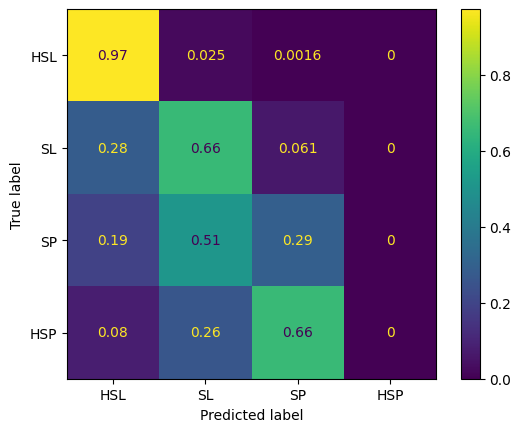

Number of unique targets: 4
Accuracy (4-way): 0.7261
Accuracy (speedup/slowdown): 0.9998


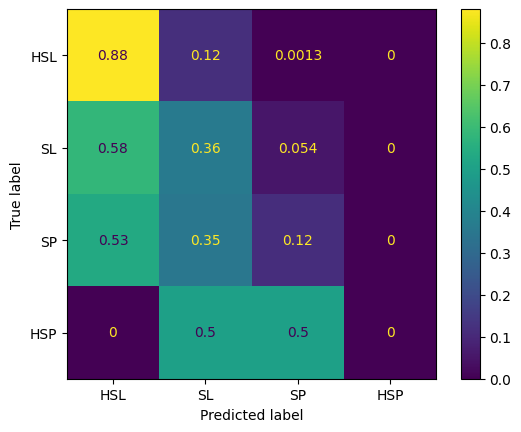

Fold 2 - Validation on LU
Number of unique targets: 4
Accuracy (4-way): 0.8703
Accuracy (speedup/slowdown): 0.9979


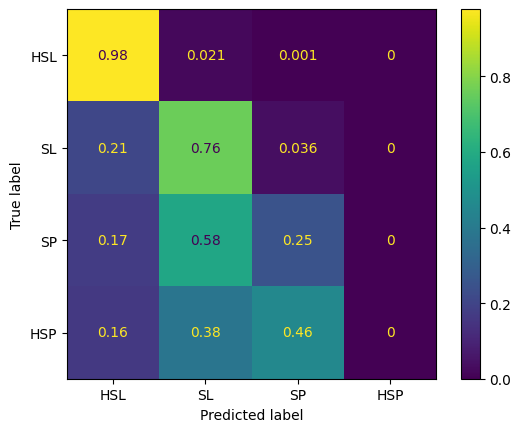

Number of unique targets: 4
Accuracy (4-way): 0.8341
Accuracy (speedup/slowdown): 0.9986


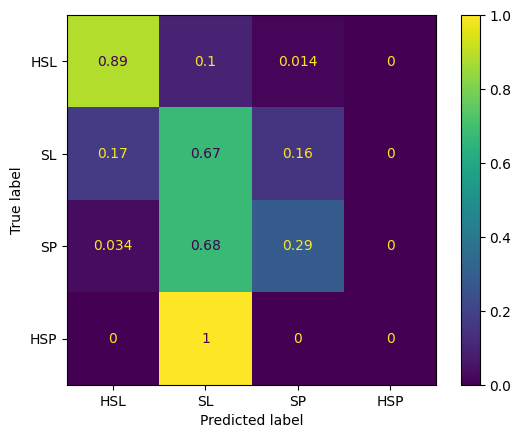

Fold 3 - Validation on UA-SNU
Number of unique targets: 4
Accuracy (4-way): 0.7733
Accuracy (speedup/slowdown): 0.9995


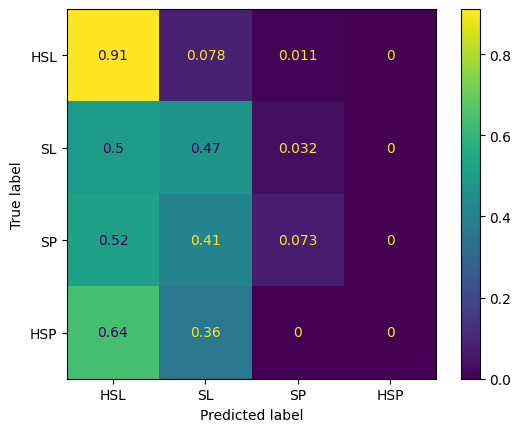

Number of unique targets: 4
Accuracy (4-way): 0.4668
Accuracy (speedup/slowdown): 0.9788


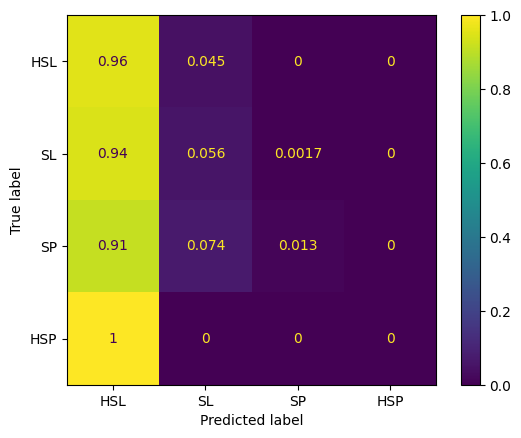

Fold 4 - Validation on CG
Number of unique targets: 4
Accuracy (4-way): 0.8617
Accuracy (speedup/slowdown): 0.9982


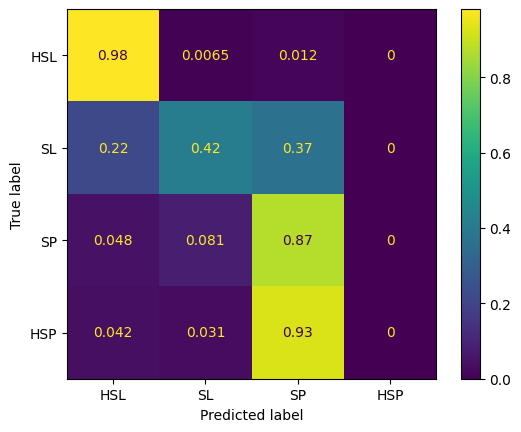

Number of unique targets: 4
Accuracy (4-way): 0.3279
Accuracy (speedup/slowdown): 0.9672


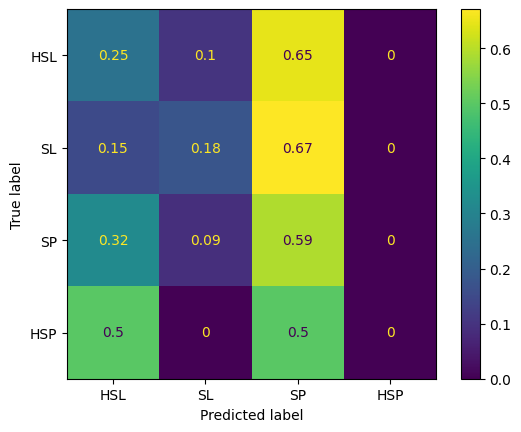

Fold 5 - Validation on SP
Number of unique targets: 4
Accuracy (4-way): 0.8828
Accuracy (speedup/slowdown): 0.9965


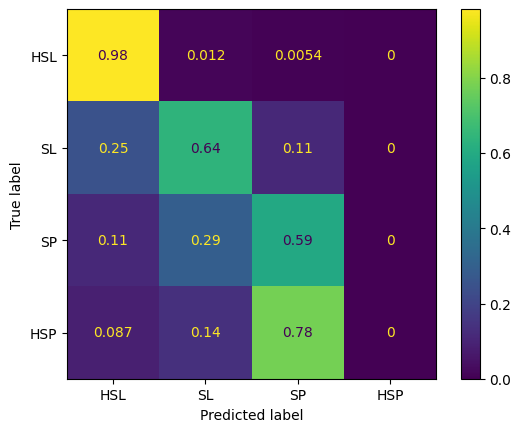

Number of unique targets: 4
Accuracy (4-way): 0.6321
Accuracy (speedup/slowdown): 1.0000


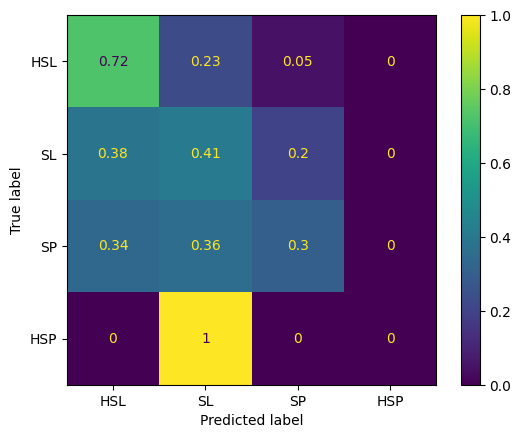

Fold 6 - Validation on MG
Number of unique targets: 4
Accuracy (4-way): 0.8901
Accuracy (speedup/slowdown): 0.9980


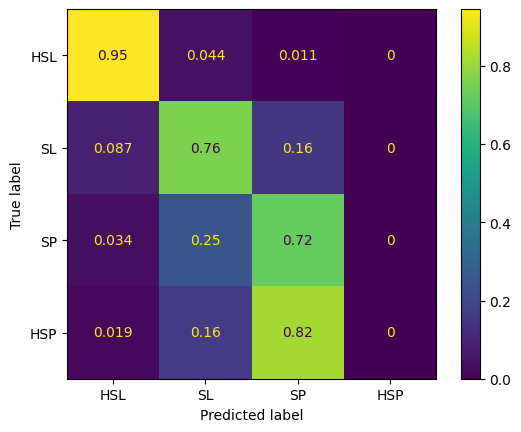

Number of unique targets: 2
Accuracy (2-way): 0.6562
Accuracy (speedup/slowdown): 1.0000


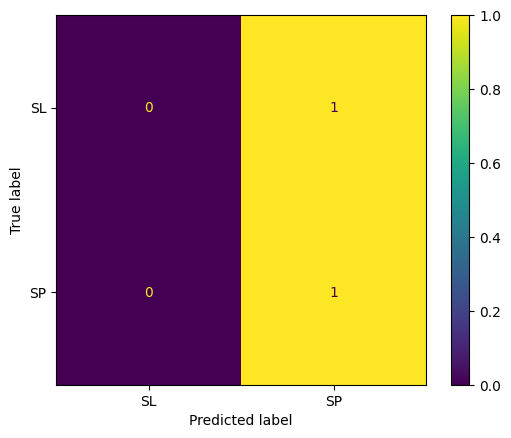

Fold 7 - Validation on FT
Number of unique targets: 4
Accuracy (4-way): 0.9018
Accuracy (speedup/slowdown): 0.9980


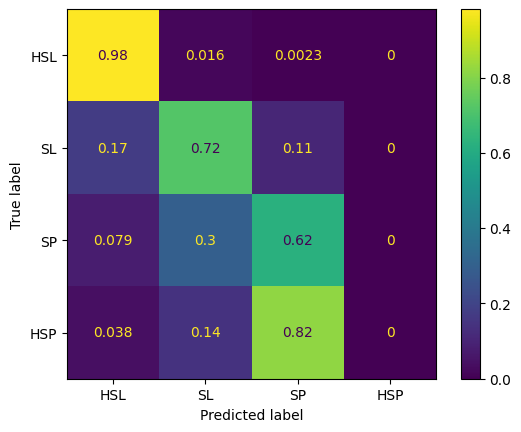

Number of unique targets: 3
Accuracy (3-way): 0.7000
Accuracy (speedup/slowdown): 1.0000


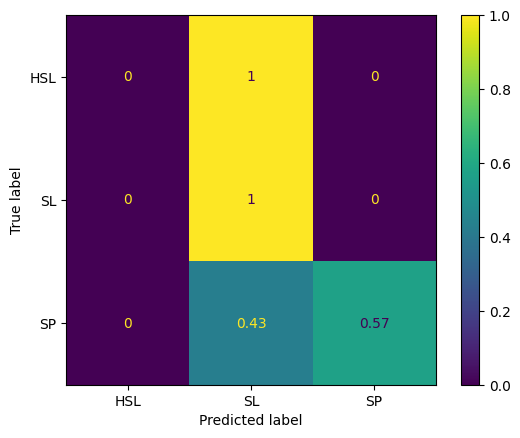

Fold 8 - Validation on IS
Number of unique targets: 4
Accuracy (4-way): 0.7885
Accuracy (speedup/slowdown): 0.9980


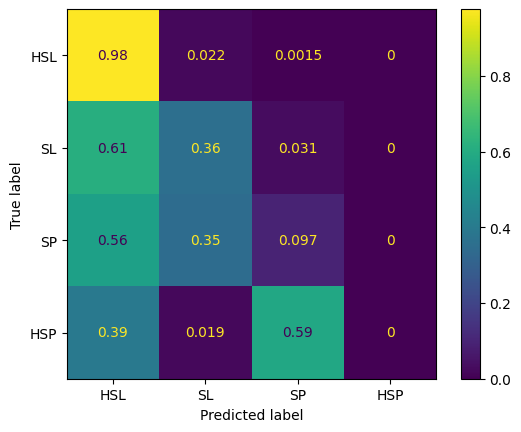

Number of unique targets: 3
Accuracy (3-way): 0.3051
Accuracy (speedup/slowdown): 1.0000


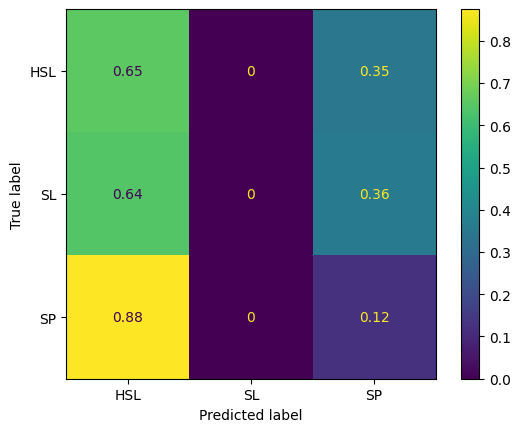

Fold 9 - Validation on EP
Number of unique targets: 4
Accuracy (4-way): 0.7831
Accuracy (speedup/slowdown): 0.9980


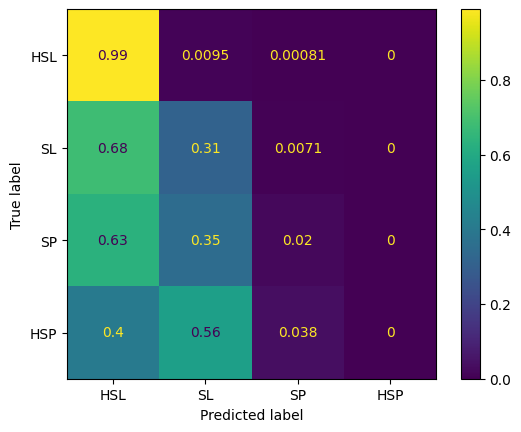

Number of unique targets: 3
Accuracy (3-way): 0.1562
Accuracy (speedup/slowdown): 1.0000


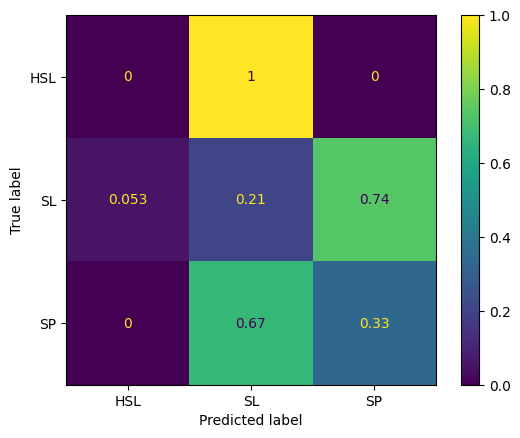

In [8]:
for i, (val_app, tr_loader, va_loader) in enumerate(loaders):
    model = models[i]
    print(f'Fold {i+1} - Validation on {val_app}')
    
    # Training predictions
    preds, tgts = model.predict(tr_loader)
    mapping = tr_loader.dataset.loop_mapping if cfg_data['min_transformations'] > 2 else None
    unique_classes_tr = tgts.unique().tolist()
    active_classes_tr = [cfg_data['classes'][i] for i in unique_classes_tr]
    eval_metrics(preds, tgts, figures=True, mapping=mapping, type=cfg_data['task'], classes=active_classes_tr)
   
    # Validation predictions
    preds, tgts = model.predict(va_loader)
    mapping = va_loader.dataset.loop_mapping if cfg_data['min_transformations'] > 2 else None
    unique_classes_va = tgts.unique().tolist()
    active_classes_va = [cfg_data['classes'][i] for i in unique_classes_va]
    eval_metrics(preds, tgts, figures=True, mapping=mapping, type=cfg_data['task'], classes=active_classes_va)

In [ ]:
from collections import Counter
import os

def generate_histograms(datasets, cfg, bins=10):
    plot_dims = (5, 2*len(datasets))
    print(plot_dims)
    title = 'Histogram Plots'
    fig, axes = plt.subplots(plot_dims[0], plot_dims[1], figsize=(plot_dims[1] * 6, plot_dims[0] * 5), subplot_kw={'projection': None})
    fig.suptitle(title, fontsize=16)
    labels = ['Train', 'Validation']

    axes_map = {'speedup': 0,
                'ref_file_size': 1,
                'all_file_size': 2,
                '#_transformations': 3,
                'loop_majority_count': 4,
                }

    for run_idx, run in enumerate(datasets):
        for col, data in enumerate(run):
            # Speedup Histograms
            speedup_counts, speedup_bin_edges, _ = axes[axes_map['speedup'], (run_idx * len(run)) + col].hist(data.Y, bins=bins)
            axes[axes_map['speedup'], (run_idx * len(run)) + col].set_title(f'Run {run_idx+1} {labels[col]} (n={len(data)})')
            axes[axes_map['speedup'], (run_idx * len(run)) + col].set_xlabel('Speedup')
            axes[axes_map['speedup'], (run_idx * len(run)) + col].set_ylabel('Frequency')
            axes[axes_map['speedup'], (run_idx * len(run)) + col].set_xticks(speedup_bin_edges)
            axes[axes_map['speedup'], (run_idx * len(run)) + col].set_yticks([5000, 10000, 15000, 20000, 25000])

            for count, edge in zip(speedup_counts, speedup_bin_edges[:-1]):
                axes[axes_map['speedup'], (run_idx * len(run)) + col].text(edge + (speedup_bin_edges[1] - speedup_bin_edges[0]) / 2,
                        count,
                        str(int(count)), 
                        ha='center', va='bottom')
                
            ids = [loop_data['id'] for loop_data in data.loop_mapping]

            # Reference File Size Histograms
            ref_file_sizes = []
            for l_id in ids:
                ref_fname = [f for f in os.listdir(os.path.join(cfg['data_path'],l_id)) if f.endswith('c.0.c')][0]
                ref_file_sizes.append(os.path.getsize(os.path.join(cfg['data_path'], l_id, ref_fname)))

            counts, bin_edges, _ = axes[axes_map['ref_file_size'], (run_idx * len(run)) + col].hist(ref_file_sizes, bins=bins)
            axes[axes_map['ref_file_size'], (run_idx * len(run)) + col].set_title(f'Run {run_idx+1} {labels[col]}  (n={len(ref_file_sizes)})')
            axes[axes_map['ref_file_size'], (run_idx * len(run)) + col].set_xlabel('Reference File Size (bytes)')
            axes[axes_map['ref_file_size'], (run_idx * len(run)) + col].set_ylabel('Frequency')
            axes[axes_map['ref_file_size'], (run_idx * len(run)) + col].set_xticks([int(e) for e in bin_edges])
            # axes[axes_map['ref_file_size'], (run_idx * len(run)) + col].set_yticks([25, 50, 75, 100, 125, 150, 175, 200])

            for count, edge in zip(counts, bin_edges[:-1]):
                axes[axes_map['ref_file_size'], (run_idx * len(run)) + col].text(edge + (bin_edges[1] - bin_edges[0]) / 2,
                        count,
                        str(int(count)), 
                        ha='center', va='bottom')
                
            # All File Size Histograms
            all_file_sizes = []
            for l_id in ids:
                fnames = [f for f in os.listdir(os.path.join(cfg['data_path'],l_id)) if f.endswith('.c')]
                for fname in fnames:
                    all_file_sizes.append(os.path.getsize(os.path.join(cfg['data_path'], l_id, fname)))

            counts, bin_edges, _ = axes[axes_map['all_file_size'], (run_idx * len(run)) + col].hist(all_file_sizes, bins=bins)
            axes[axes_map['all_file_size'], (run_idx * len(run)) + col].set_title(f'Run {run_idx+1} {labels[col]}  (n={len(all_file_sizes)})')
            axes[axes_map['all_file_size'], (run_idx * len(run)) + col].set_xlabel('File Size (bytes)')
            axes[axes_map['all_file_size'], (run_idx * len(run)) + col].set_ylabel('Frequency')
            axes[axes_map['all_file_size'], (run_idx * len(run)) + col].set_xticks([int(e) for e in bin_edges])
            # axes[axes_map['all_file_size'], (run_idx * len(run)) + col].set_yticks([25, 50, 75, 100, 125, 150, 175, 200])

            for count, edge in zip(counts, bin_edges[:-1]):
                axes[axes_map['all_file_size'], (run_idx * len(run)) + col].text(edge + (bin_edges[1] - bin_edges[0]) / 2,
                        count,
                        str(int(count)), 
                        ha='center', va='bottom')

            # # Transformations Histograms
            num_transformations = []
            for l_id in ids:
                num_transformations.append(len([f for f in os.listdir(os.path.join(cfg['data_path'],l_id)) if f.endswith('.c')]))

            counts, bin_edges, _ = axes[axes_map['#_transformations'], (run_idx * len(run)) + col].hist(num_transformations, bins=bins)
            axes[axes_map['#_transformations'], (run_idx * len(run)) + col].set_title(f'Run {run_idx+1} {labels[col]} (n={len(num_transformations)})')
            axes[axes_map['#_transformations'], (run_idx * len(run)) + col].set_xlabel('# Transformations')
            axes[axes_map['#_transformations'], (run_idx * len(run)) + col].set_ylabel('Frequency')
            axes[axes_map['#_transformations'], (run_idx * len(run)) + col].set_xticks(bin_edges)
            # axes[axes_map['#_transformations'], (run_idx * len(run)) + col].set_yticks([200, 400, 600, 800, 1000])

            for count, edge in zip(counts, bin_edges[:-1]):
                axes[axes_map['#_transformations'], (run_idx * len(run)) + col].text(edge + (bin_edges[1] - bin_edges[0]) / 2,
                        count,
                        str(int(count)), 
                        ha='center', va='bottom')
                
            # Loop Count Majority Class
            loop_classes = []
            for l_id in ids:
                fname = os.path.join(cfg['data_path'], l_id, f'{l_id}_speedup_refs.pt')
                speedups = torch.load(fname, weights_only=True, map_location='cpu')
                loop_id_stats = []
                for i in range(len(cfg['class_splits'])-1):
                    loop_id_stats.append(torch.where((speedups > cfg['class_splits'][i]) & (speedups < cfg['class_splits'][i+1]), 1, 0).sum())
                loop_classes.append(cfg['classes'][loop_id_stats.index(max(loop_id_stats))])

            counts = Counter(loop_classes)
            counts = Counter({key: counts[key] for key in cfg['classes']})
            
            axes[axes_map['loop_majority_count'], (run_idx * len(run)) + col].bar(counts.keys(), counts.values())
            axes[axes_map['loop_majority_count'], (run_idx * len(run)) + col].set_title(f'Run {run_idx+1} {labels[col]} (n={len(loop_classes)})')
            axes[axes_map['loop_majority_count'], (run_idx * len(run)) + col].set_xlabel('Majority Class')
            axes[axes_map['loop_majority_count'], (run_idx * len(run)) + col].set_ylabel('Frequency')
            # axes[axes_map['loop_majority_count'], (run_idx * len(run)) + col].set_yticks([50, 100, 150, 200, 250, 300, 350])

            for count, edge in zip(counts.values(), counts.keys()):
                axes[axes_map['loop_majority_count'], (run_idx * len(run)) + col].text(edge,
                        count,
                        str(int(count)), 
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    # plt.savefig('plots.png')

In [ ]:
datasets = [[tr_loader.dataset, va_loader.dataset]]
generate_histograms(datasets, cfg_data, bins=5)

In [ ]:
##########################################
# REQUIRES A SECOND LOOK
##########################################
class BidirectionalCrossAttention(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.n_embeddings = cfg['n_embeddings']
        self.projection = nn.Sequential(
            nn.Linear(cfg['emb_dim'], cfg['emb_latent_dim']),
            nn.LayerNorm(cfg['emb_latent_dim'])
        )
        latent_dim = cfg['emb_latent_dim'] * self.n_embeddings
        out_dim = 1 if cfg['task'] == 'regression' else cfg['num_classes']
        self.head = MLPHead(latent_dim+cfg['transf_dim'], out_dim, cfg['use_layer_norm'], cfg['dropout'], cfg['n_hid_layers'])
        self.cross_attention1 = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=4, dropout=cfg['dropout'], batch_first=True, kdim=cfg['transf_dim'], vdim=cfg['transf_dim'])
        self.cross_attention2 = nn.MultiheadAttention(embed_dim=cfg['transf_dim'], num_heads=4, dropout=cfg['dropout'], batch_first=True, kdim=latent_dim, vdim=latent_dim)

    def forward(self, batch):
        emb_proj_1 = self.projection(batch[0])
        if self.n_embeddings == 1:
            features1, _ = self.cross_attention1(query=emb_proj_1, key=batch[1], value=batch[1])
            features2, _ = self.cross_attention2(query=batch[1], key=emb_proj_1, value=emb_proj_1)
            return self.head(torch.cat([emb_proj_1+features1, batch[1]+features2], dim=1)).squeeze(-1)
        elif self.n_embeddings == 2:
            emb_proj_2 = self.projection(batch[1])
            embs = torch.cat([emb_proj_1, emb_proj_2], dim=1)
            features1, _ = self.cross_attention1(query=embs, key=batch[2], value=batch[2])
            features2, _ = self.cross_attention2(query=batch[2], key=embs, value=embs)
            return self.head(torch.cat([embs+features1, batch[2]+features2], dim=1)).squeeze(-1)